# Correlation: generation params vs hallucination

This notebook analyzes outputs under `output/` to measure how generation parameters (CREATIVITY levels and LENGTH_WORDS) relate to hallucination.

**Robustness note:** metrics and plots below use data aggregated per model to avoid bias from unequal sample sizes across models.

Definition used here:
- **Hallucination rate** = 1 - mean(is_supported) across extracted claims for a prompt.

You can filter to LENGTH_WORDS=50 (the focus requested) using the `LENGTH_FILTER` variable below.


In [292]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

OUTPUT_ROOT = Path('../output/longwiki-hybrid2')
LENGTH_FILTER = None  # set to None to analyze all lengths

CREATIVITY_ORDER = ['FACTUAL', 'HYBRID', 'VERY_CREATIVE']
CREATIVITY_RANK = {k: i for i, k in enumerate(CREATIVITY_ORDER)}


In [293]:
def _read_jsonl(path):
    rows = []
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def load_run(run_dir):
    # generation metadata per prompt
    gen_rows = _read_jsonl(run_dir / 'generation.jsonl')
    gen = pd.DataFrame({
        'prompt': [r.get('prompt') for r in gen_rows],
        'creativity_level': [r.get('creativity_level') for r in gen_rows],
        'length_words': [r.get('length_words') for r in gen_rows],
        'task': [r.get('task') for r in gen_rows],
        'title': [r.get('title') for r in gen_rows],
    })

    # run-level metadata
    cfg = json.loads((run_dir / 'run_config.json').read_text(encoding='utf-8'))
    model_name = cfg.get('model_name')
    if not model_name:
        model_name = cfg.get('args', {}).get('model')
        if isinstance(model_name, str) and '/' in model_name:
            model_name = model_name.split('/')[-1]
    temperature = float(cfg.get('args', {}).get('temperature'))

    # claim-level evals
    claims = pd.read_csv(run_dir / 'output.csv')
    # ensure boolean
    claims['is_supported'] = claims['is_supported'].astype(str).str.lower().eq('true')

    # aggregate per prompt
    agg = (
        claims.groupby('prompt', as_index=False)
        .agg(
            n_claims=('is_supported', 'size'),
            support_rate=('is_supported', 'mean'),
        )
    )
    agg['hallucination_rate'] = 1.0 - agg['support_rate']

    # join
    df = gen.merge(agg, on='prompt', how='left')
    df['run_dir'] = run_dir.name
    df['model_name'] = model_name
    df['temperature'] = temperature
    return df


In [294]:
run_dirs = [p for p in OUTPUT_ROOT.iterdir() if p.is_dir()]
run_dirs = sorted(run_dirs, key=lambda p: p.name)
len(run_dirs), run_dirs[:3]


(34,
 [PosixPath('../output/longwiki-hybrid2/gemini-3-flash-preview__static_prompts_len150_mgemini-3-flash-preview_t0.0'),
  PosixPath('../output/longwiki-hybrid2/gemini-3-flash-preview__static_prompts_len150_mgemini-3-flash-preview_t0.25'),
  PosixPath('../output/longwiki-hybrid2/gemini-3-flash-preview__static_prompts_len150_mgemini-3-flash-preview_t0.5')])

In [295]:
all_rows = []
for rd in run_dirs:
    try:
        all_rows.append(load_run(rd))
    except Exception as e:
        print(f'skipping {rd}: {e}')

df = pd.concat(all_rows, ignore_index=True)
df.shape


skipping ../output/longwiki-hybrid2/gemini-3-flash-preview__static_prompts_len300_mgemini-3-flash-preview_t0.0: [Errno 2] No such file or directory: '../output/longwiki-hybrid2/gemini-3-flash-preview__static_prompts_len300_mgemini-3-flash-preview_t0.0/output.csv'
skipping ../output/longwiki-hybrid2/mistral-small-creative__static_prompts_len150_mmistral-small-creative_t0.75: [Errno 2] No such file or directory: '../output/longwiki-hybrid2/mistral-small-creative__static_prompts_len150_mmistral-small-creative_t0.75/output.csv'
skipping ../output/longwiki-hybrid2/mistral-small-creative__static_prompts_len300_mmistral-small-creative_t0.0: [Errno 2] No such file or directory: '../output/longwiki-hybrid2/mistral-small-creative__static_prompts_len300_mmistral-small-creative_t0.0/generation.jsonl'
skipping ../output/longwiki-hybrid2/promptset__static_prompts_len50: [Errno 2] No such file or directory: '../output/longwiki-hybrid2/promptset__static_prompts_len50/generation.jsonl'


(900, 11)

In [296]:
# Liste des sujets (titres) utilisés dans les prompts
topics = sorted(df['title'].dropna().unique())
len(topics)
topics


['200 (Stargate SG-1)',
 'Air well (condenser)',
 'Beth Hamedrash Hagodol',
 "Bolesław I's intervention in the Kievan succession crisis",
 'Common firecrest',
 'Ditton, Kent',
 'Dookudu',
 'From This Moment On (Shania Twain song)',
 'G (New York City Subway service)',
 'Gun Court',
 'Hedonic hunger',
 'Heidi Cruz',
 'Howard Kippenberger',
 'Hugh Beadle',
 'Johann Lamont',
 'Lake Cahuilla',
 'Leatherface (2017 film)',
 'Lee Hughes',
 'Lisa Nowak',
 'Lita (wrestler)',
 'Matrilineal society of Meghalaya',
 "Number 1's (Mariah Carey album)",
 'P.T. (video game)',
 'Porcelain Black',
 'Steve Javie',
 'The Boat Race 1978',
 'Treehouse of Horror XIX',
 'W New York Union Square',
 'Whitney Dean',
 'Wolf 359']

## Summary tables

Focus on LENGTH_WORDS=50 by default (set `LENGTH_FILTER=None` to include all).
Metrics are computed from model-aggregated data (each model contributes equally).


In [297]:
df_f = df.copy()
if LENGTH_FILTER is not None:
    df_f = df_f[df_f['length_words'].isin(LENGTH_FILTER)]

# Base: only rows with model info
# This avoids bias from uneven prompt counts across models
# and keeps each model's data aggregated.
df_f = df_f[df_f['model_name'].notna()].copy()
df_f['model_family'] = df_f['model_name']

AGG_COLS = ['model_family', 'temperature', 'length_words', 'creativity_level', 'task']
df_model_agg = (
    df_f.groupby(AGG_COLS, as_index=False)
    .agg(
        n_prompts=('prompt', 'count'),
        hallucination_rate=('hallucination_rate', 'mean'),
        support_rate=('support_rate', 'mean'),
        n_claims=('n_claims', 'mean'),
    )
)

# Base dataset for robust metrics (each row = model aggregated)
df_base = df_model_agg.copy()

summary = (
    df_base.groupby(['length_words', 'creativity_level'], as_index=False)
    .agg(
        n_models=('model_family', 'nunique'),
        hallucination_rate_mean=('hallucination_rate', 'mean'),
        hallucination_rate_median=('hallucination_rate', 'median'),
        support_rate_mean=('support_rate', 'mean'),
        n_claims_mean=('n_claims', 'mean'),
        n_prompts_mean=('n_prompts', 'mean'),
    )
)
summary['creativity_level'] = pd.Categorical(summary['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
summary = summary.sort_values(['length_words', 'creativity_level'])
summary


,length_words,creativity_level,n_models,hallucination_rate_mean,hallucination_rate_median,support_rate_mean,n_claims_mean,n_prompts_mean
0,50,FACTUAL,3,0.631282,0.597978,0.368718,31.994378,8.0
1,50,HYBRID,3,0.628061,0.625901,0.371939,34.826389,3.0
2,50,VERY_CREATIVE,3,0.736458,0.771390,0.263542,33.358333,4.0
3,150,FACTUAL,3,0.594774,0.529790,0.405226,42.144120,8.0
4,150,HYBRID,3,0.613033,0.595981,0.386967,42.318182,3.0
5,150,VERY_CREATIVE,3,0.680635,0.687583,0.319365,43.016667,4.0
6,300,FACTUAL,2,0.643190,0.594628,0.356810,56.583475,8.0
7,300,HYBRID,2,0.625317,0.547753,0.374683,60.797619,3.0
8,300,VERY_CREATIVE,2,0.679868,0.647290,0.320132,61.217857,4.0


In [298]:
# Ordre fixe des classes de créativité
df['creativity_level'] = pd.Categorical(df['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_f' in globals():
    df_f['creativity_level'] = pd.Categorical(df_f['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_base' in globals():
    df_base['creativity_level'] = pd.Categorical(df_base['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_model_agg' in globals():
    df_model_agg['creativity_level'] = pd.Categorical(df_model_agg['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_mg' in globals():
    df_mg['creativity_level'] = pd.Categorical(df_mg['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_mg_f' in globals():
    df_mg_f['creativity_level'] = pd.Categorical(df_mg_f['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'summary' in globals():
    summary['creativity_level'] = pd.Categorical(summary['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)


**Note:** Les graphiques utilisent l'ordre FIXE des classes de créativité: FACTUAL → HYBRID → VERY_CREATIVE.


In [299]:
# Pivot view for quick comparison
pivot = summary.pivot(index='creativity_level', columns='length_words', values='hallucination_rate_mean').reindex(CREATIVITY_ORDER)
pivot


length_words,50,150,300
creativity_level,,,
FACTUAL,0.631282,0.594774,0.643190
HYBRID,0.628061,0.613033,0.625317
VERY_CREATIVE,0.736458,0.680635,0.679868


## Correlation analysis

- Pearson between LENGTH_WORDS and hallucination_rate (numeric).
- Spearman between creativity rank and hallucination_rate (ordinal encoding).
- Computed on model-aggregated data to reduce sample-size bias.


In [300]:
df_corr = df_base.dropna(subset=['hallucination_rate', 'length_words', 'creativity_level']).copy()

# numeric correlation with length_words
pearson_len = df_corr[['length_words', 'hallucination_rate']].corr(method='pearson').iloc[0,1]

# ordinal encoding for creativity (order assumed)
df_corr['creativity_rank'] = df_corr['creativity_level'].map(CREATIVITY_RANK)
spearman_creativity = df_corr[['creativity_rank', 'hallucination_rate']].corr(method='spearman').iloc[0,1]

pearson_len, spearman_creativity


(-0.046117530916905465, 0.2313846230661732)

## Corrélation multi-paramètres (créativité, longueur, température, tâche)

Corrélation (Pearson) entre le score d'hallucination et: créativité (ordinal), longueur (mots), température, et tâches ciblées.


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_26406/594489851.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, orient='h', palette='viridis')


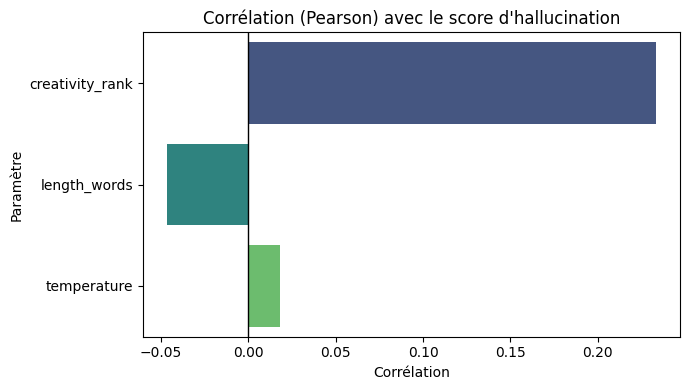

In [301]:
# Corrélation avec hallucination: créativité, longueur, température, tâches
import matplotlib.pyplot as plt
import seaborn as sns

TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']

df_corr3 = df_base[df_base['task'].isin(TASKS_FOCUS)].copy()
df_corr3['creativity_rank'] = df_corr3['creativity_level'].map(CREATIVITY_RANK)

# One-hot pour les tâches (corrélation point-bisériale vs hallucination)
task_dummies = pd.get_dummies(df_corr3['task'], prefix='task')

corr_df = pd.concat([
    df_corr3[['hallucination_rate', 'length_words', 'temperature', 'creativity_rank']],
    task_dummies
], axis=1)

corr = (
    corr_df
    .corr(method='pearson')['hallucination_rate']
    .drop('hallucination_rate')
)

ordered_cols = ['creativity_rank', 'length_words', 'temperature']
corr = corr.reindex([c for c in ordered_cols if c in corr.index])
corr

# Graphique: corrélation vs hallucination
plt.figure(figsize=(7,4))
sns.barplot(x=corr.values, y=corr.index, orient='h', palette='viridis')
plt.axvline(0, color='black', linewidth=1)
plt.title("Corrélation (Pearson) avec le score d'hallucination")
plt.xlabel('Corrélation')
plt.ylabel('Paramètre')
plt.tight_layout()
plt.show()


## Impact créativité et température par tâche

Graphiques par tâche montrant l'effet de la créativité (ordinal) et de la température sur le score d'hallucination.


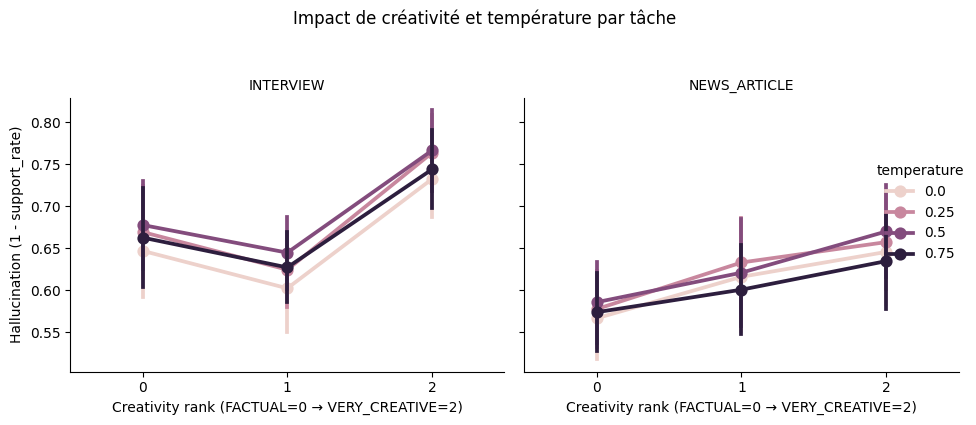

In [302]:
# Impact créativité (rank) et température par tâche
TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']

df_task_ct = df_base[df_base['task'].isin(TASKS_FOCUS)].copy()
df_task_ct['creativity_rank'] = df_task_ct['creativity_level'].map(CREATIVITY_RANK)

g = sns.catplot(
    data=df_task_ct,
    x='creativity_rank', y='hallucination_rate',
    hue='temperature', col='task',
    kind='point', estimator='mean', errorbar='se',
    height=4, aspect=1.1,
)
g.set_titles('{col_name}')
g.set_axis_labels('Creativity rank (FACTUAL=0 → VERY_CREATIVE=2)', 'Hallucination (1 - support_rate)')
g.fig.suptitle('Impact de créativité et température par tâche', y=1.05)
plt.tight_layout()
plt.show()


## Optional: split by model and temperature


In [303]:
by_model = (
    df_model_agg.groupby(['model_family', 'temperature', 'length_words', 'creativity_level'], as_index=False)
    .agg(
        n_tasks=('task', 'nunique'),
        hallucination_rate_mean=('hallucination_rate', 'mean'),
    )
)
by_model.sort_values(['model_family', 'temperature', 'length_words', 'creativity_level']).head(20)


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_26406/893324942.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model_agg.groupby(['model_family', 'temperature', 'length_words', 'creativity_level'], as_index=False)


ValueError: Length of values (90) does not match length of index (108)

## Comparaison des modèles (Mistral vs Gemini)

Ces graphiques comparent directement les deux familles de modèles.


In [ ]:
# Comparaison multi-modèles (nom de modèle issu de run_config.json)
import matplotlib.pyplot as plt
import seaborn as sns

# Utilise la base agrégée par modèle pour éviter les biais de taille d'échantillon
df_mg = df_base.copy()
MODEL_ORDER = sorted(df_mg['model_family'].unique())

# Appliquer le même filtre de longueur si défini (déjà fait en amont)
df_mg_f = df_mg.copy()


## Dataframes séparés par modèle

Chaque modèle est isolé dans son propre dataframe pour calculer les métriques sans biais de taille d’échantillon.


In [ ]:
# Dataframes par modèle
from IPython.display import display

MODEL_LIST = sorted(df_model_agg['model_family'].dropna().unique())
MODEL_DFS = {m: df_model_agg[df_model_agg['model_family'] == m].copy() for m in MODEL_LIST}

# aperçu des tailles par modèle
sizes = {m: len(dfm) for m, dfm in MODEL_DFS.items()}
sizes


## Résultats par modèle (métriques + graphiques)

Duplique les métriques et graphiques pour chaque modèle testé lorsqu'il y en a plusieurs.


In [ ]:
# Résultats par modèle (métriques + graphiques)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']

MODEL_LIST = sorted(MODEL_DFS.keys())
HAS_MULTI_MODELS = len(MODEL_LIST) > 1
MODEL_LIST, HAS_MULTI_MODELS

if HAS_MULTI_MODELS:
    for model in MODEL_LIST:
        df_m = MODEL_DFS[model].copy()
        print(f'=== Modèle: {model} ===')

        # Métriques: table récapitulative
        summary_m = (
            df_m.groupby(['length_words', 'creativity_level'], as_index=False)
            .agg(
                n_prompts=('prompt', 'count'),
                hallucination_rate_mean=('hallucination_rate', 'mean'),
                hallucination_rate_median=('hallucination_rate', 'median'),
                support_rate_mean=('support_rate', 'mean'),
                n_claims_mean=('n_claims', 'mean'),
            )
        )
        summary_m['creativity_level'] = pd.Categorical(summary_m['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
        summary_m = summary_m.sort_values(['length_words', 'creativity_level'])
        display(summary_m)

        # Corrélations principales
        df_corr_m = df_m.dropna(subset=['hallucination_rate', 'length_words', 'creativity_level']).copy()
        df_corr_m['creativity_rank'] = df_corr_m['creativity_level'].map(CREATIVITY_RANK)
        pearson_len = df_corr_m[['length_words', 'hallucination_rate']].corr(method='pearson').iloc[0,1]
        spearman_creativity = df_corr_m[['creativity_rank', 'hallucination_rate']].corr(method='spearman').iloc[0,1]
        print('Pearson length_words vs hallucination_rate:', pearson_len)
        print('Spearman creativity_rank vs hallucination_rate:', spearman_creativity)

        # Corrélation multi-paramètres (avec tâches ciblées)
        df_corr3_m = df_m[df_m['task'].isin(TASKS_FOCUS)].copy()
        if not df_corr3_m.empty:
            df_corr3_m['creativity_rank'] = df_corr3_m['creativity_level'].map(CREATIVITY_RANK)
            task_dummies = pd.get_dummies(df_corr3_m['task'], prefix='task')
            corr_df = pd.concat([
                df_corr3_m[['hallucination_rate', 'length_words', 'temperature', 'creativity_rank']],
                task_dummies
            ], axis=1)
            corr = (
                corr_df
                .corr(method='pearson')['hallucination_rate']
                .drop('hallucination_rate')
            )
            ordered_cols = ['creativity_rank', 'length_words', 'temperature'] + [f'task_{t}' for t in TASKS_FOCUS]
            corr = corr.reindex([c for c in ordered_cols if c in corr.index])
            display(corr)

            plt.figure(figsize=(7,4))
            sns.barplot(x=corr.values, y=corr.index, orient='h', palette='viridis')
            plt.axvline(0, color='black', linewidth=1)
            plt.title(f'Corrélation (Pearson) vs hallucination ({model})')
            plt.xlabel('Corrélation')
            plt.ylabel('Paramètre')
            plt.tight_layout()
            plt.show()

        # Graphique: créativité vs hallucination
        plt.figure(figsize=(7,4))
        sns.pointplot(data=df_m, x='creativity_level', y='hallucination_rate', errorbar='se', order=CREATIVITY_ORDER)
        plt.title(f"Score d'hallucination par classe de créativité ({model})")
        plt.xlabel('Créativité')
        plt.ylabel('Hallucination (1 - support_rate)')
        plt.tight_layout()
        plt.show()

        # Graphiques par tâche
        task_order = sorted(df_m['task'].dropna().unique())
        if task_order:
            plt.figure(figsize=(7,4))
            sns.barplot(data=df_m, x='task', y='hallucination_rate', estimator='mean', errorbar='se', order=task_order)
            plt.title(f'Hallucination moyenne par tâche ({model})')
            plt.xlabel('Tâche')
            plt.ylabel('Hallucination (1 - support_rate)')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(7,4))
            sns.boxplot(data=df_m, x='task', y='hallucination_rate', order=task_order)
            plt.title(f'Distribution hallucination par tâche ({model})')
            plt.xlabel('Tâche')
            plt.ylabel('Hallucination (1 - support_rate)')
            plt.tight_layout()
            plt.show()

        # Impact créativité (rank) et température par tâche
        df_task_ct_m = df_m[df_m['task'].isin(TASKS_FOCUS)].copy()
        if not df_task_ct_m.empty:
            df_task_ct_m['creativity_rank'] = df_task_ct_m['creativity_level'].map(CREATIVITY_RANK)
            g = sns.catplot(
                data=df_task_ct_m,
                x='creativity_rank', y='hallucination_rate',
                hue='temperature', col='task',
                kind='point', estimator='mean', errorbar='se',
                height=4, aspect=1.1,
            )
            g.set_titles('{col_name}')
            g.set_axis_labels('Creativity rank (FACTUAL=0 → VERY_CREATIVE=2)', 'Hallucination (1 - support_rate)')
            g.fig.suptitle(f'Impact de créativité et température par tâche ({model})', y=1.05)
            plt.tight_layout()
            plt.show()
else:
    print('Un seul modèle détecté: les sections globales suffisent.')


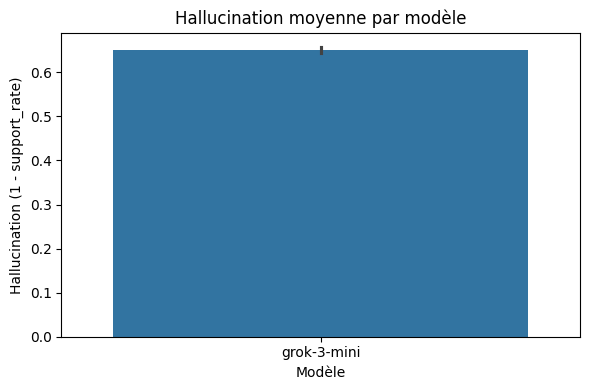

In [ ]:
# 1) Barplot: hallucination moyenne par modèle (toutes créativités)
plt.figure(figsize=(6,4))
sns.barplot(data=df_mg_f, x='model_family', y='hallucination_rate', estimator='mean', errorbar='se', order=MODEL_ORDER)
plt.title('Hallucination moyenne par modèle')
plt.xlabel('Modèle')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


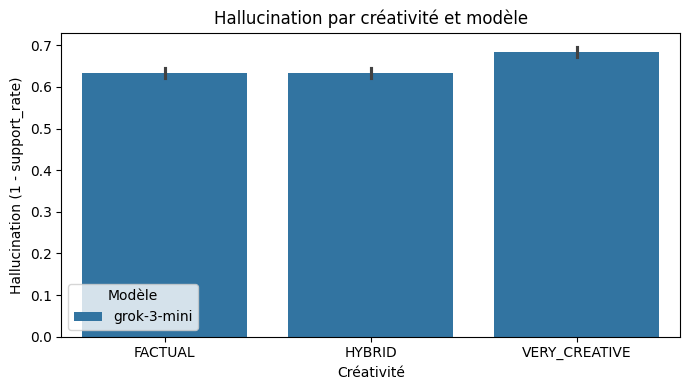

In [ ]:
# 2) Barplot: hallucination par créativité et modèle
plt.figure(figsize=(7,4))
sns.barplot(
    data=df_mg_f,
    x='creativity_level', y='hallucination_rate', hue='model_family',
    estimator='mean', errorbar='se', order=CREATIVITY_ORDER, hue_order=MODEL_ORDER
)
plt.title('Hallucination par créativité et modèle')
plt.xlabel('Créativité')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


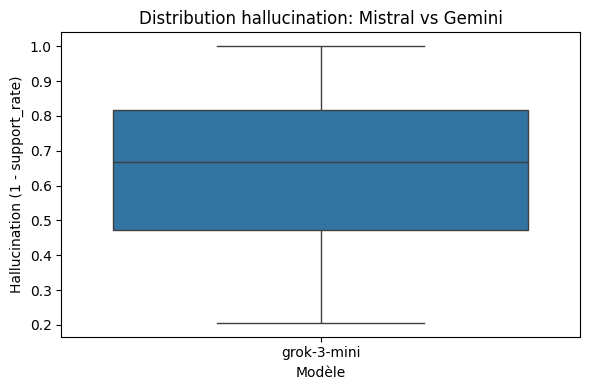

In [ ]:
# 3) Boxplot: distribution par modèle
plt.figure(figsize=(6,4))
sns.boxplot(data=df_mg_f, x='model_family', y='hallucination_rate')
plt.title('Distribution hallucination: Mistral vs Gemini')
plt.xlabel('Modèle')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_26406/107278263.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mg.groupby(['model_family', 'creativity_level', 'length_words'], as_index=False)


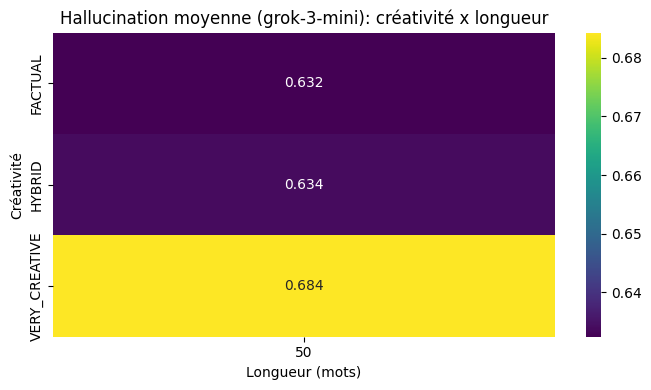

In [ ]:
# 4) Heatmap: créativité x longueur par modèle (moyenne)
heat_mg = (
    df_mg.groupby(['model_family', 'creativity_level', 'length_words'], as_index=False)
    .agg(hallucination_rate_mean=('hallucination_rate', 'mean'))
)
for mf in MODEL_ORDER:
    hm = heat_mg[heat_mg['model_family'] == mf]
    hm_p = hm.pivot(index='creativity_level', columns='length_words', values='hallucination_rate_mean').reindex(CREATIVITY_ORDER)
    plt.figure(figsize=(7,4))
    sns.heatmap(hm_p, annot=True, fmt='.3f', cmap='viridis')
    plt.title(f'Hallucination moyenne ({mf}): créativité x longueur')
    plt.xlabel('Longueur (mots)')
    plt.ylabel('Créativité')
    plt.tight_layout()
    plt.show()


## Graphiques supplémentaires: température et tâche


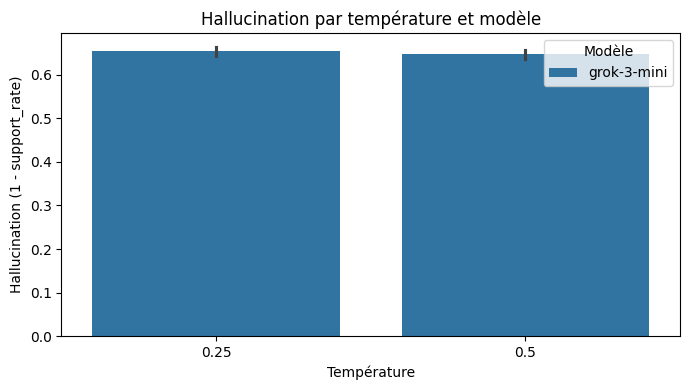

In [ ]:
# Filtre multi-modèles déjà défini dans df_mg / df_mg_f
# 1) Température: comparaison par modèle
plt.figure(figsize=(7,4))
sns.barplot(data=df_mg, x='temperature', y='hallucination_rate', hue='model_family', estimator='mean', errorbar='se', hue_order=MODEL_ORDER)
plt.title('Hallucination par température et modèle')
plt.xlabel('Température')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


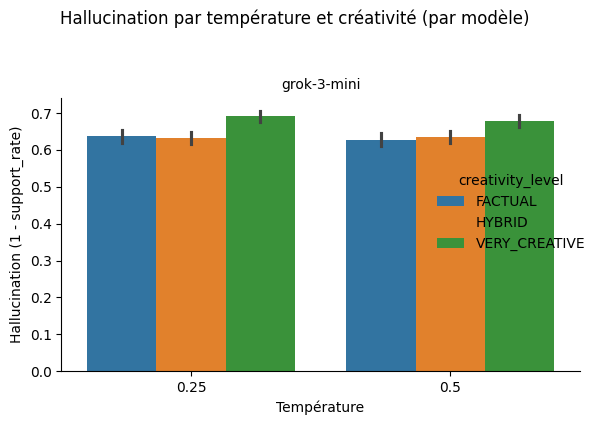

In [ ]:
# 2) Température + créativité: facettes par modèle
g = sns.catplot(
    data=df_mg,
    x='temperature', y='hallucination_rate',
    hue='creativity_level', col='model_family',
    kind='bar', estimator='mean', errorbar='se',
    height=4, aspect=1.1,
    hue_order=CREATIVITY_ORDER, col_order=MODEL_ORDER
)
g.set_titles('{col_name}')
g.set_axis_labels('Température', 'Hallucination (1 - support_rate)')
g.fig.suptitle('Hallucination par température et créativité (par modèle)', y=1.05)
plt.tight_layout()
plt.show()


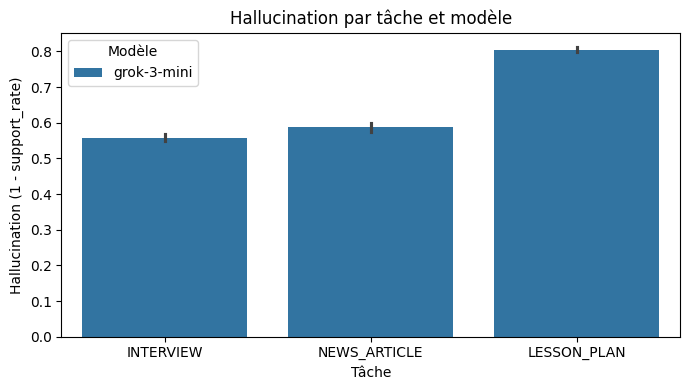

In [ ]:
# 3) Par tâche (INTERVIEW vs NEWS_ARTICLE, etc.)
plt.figure(figsize=(7,4))
sns.barplot(data=df_mg_f, x='task', y='hallucination_rate', hue='model_family', estimator='mean', errorbar='se', hue_order=MODEL_ORDER)
plt.title('Hallucination par tâche et modèle')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


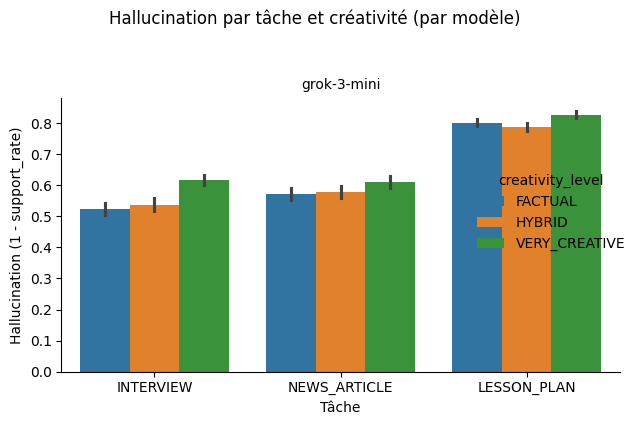

In [ ]:
# 4) Par tâche + créativité (facettes par modèle)
g = sns.catplot(
    data=df_mg_f,
    x='task', y='hallucination_rate',
    hue='creativity_level', col='model_family',
    kind='bar', estimator='mean', errorbar='se',
    height=4, aspect=1.2,
    hue_order=CREATIVITY_ORDER, col_order=MODEL_ORDER
)
g.set_titles('{col_name}')
g.set_axis_labels('Tâche', 'Hallucination (1 - support_rate)')
g.fig.suptitle('Hallucination par tâche et créativité (par modèle)', y=1.05)
plt.tight_layout()
plt.show()


## Corrélations créativité ↔ hallucination


In [ ]:
# Corrélations avec créativité (ordinal) et hallucination
df_corr2 = df_base.dropna(subset=['hallucination_rate', 'creativity_level']).copy()
df_corr2['creativity_rank'] = df_corr2['creativity_level'].map(CREATIVITY_RANK)

pearson_creativity = df_corr2[['creativity_rank', 'hallucination_rate']].corr(method='pearson').iloc[0,1]
spearman_creativity = df_corr2[['creativity_rank', 'hallucination_rate']].corr(method='spearman').iloc[0,1]
kendall_creativity = df_corr2[['creativity_rank', 'hallucination_rate']].corr(method='kendall').iloc[0,1]

pearson_creativity, spearman_creativity, kendall_creativity


(0.10373391194600937, 0.10396621006374741, 0.08078113330862197)

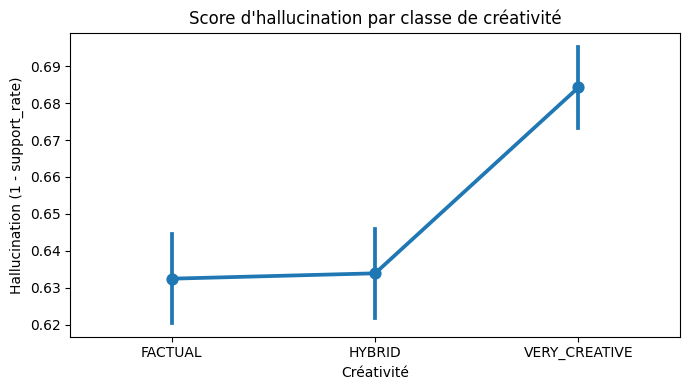

In [ ]:
# Graphique: classes créatives vs score d'hallucination (moyenne + IC)
plt.figure(figsize=(7,4))
sns.pointplot(data=df_base, x='creativity_level', y='hallucination_rate', errorbar='se', order=CREATIVITY_ORDER)
plt.title("Score d'hallucination par classe de créativité")
plt.xlabel('Créativité')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


## Graphiques par tâche


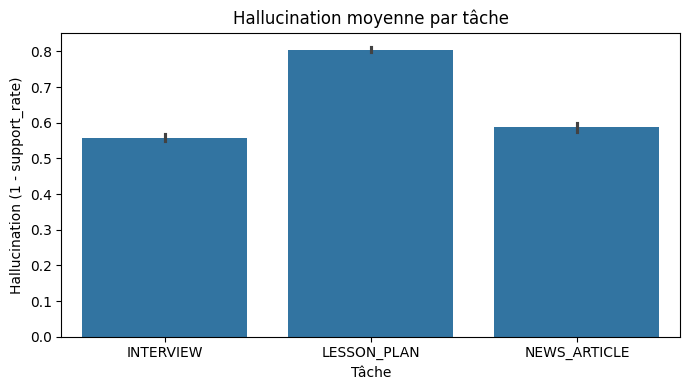

In [ ]:
# 1) Hallucination moyenne par tâche
task_order = sorted(df_base['task'].dropna().unique())
plt.figure(figsize=(7,4))
sns.barplot(data=df_base, x='task', y='hallucination_rate', estimator='mean', errorbar='se', order=task_order)
plt.title('Hallucination moyenne par tâche')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


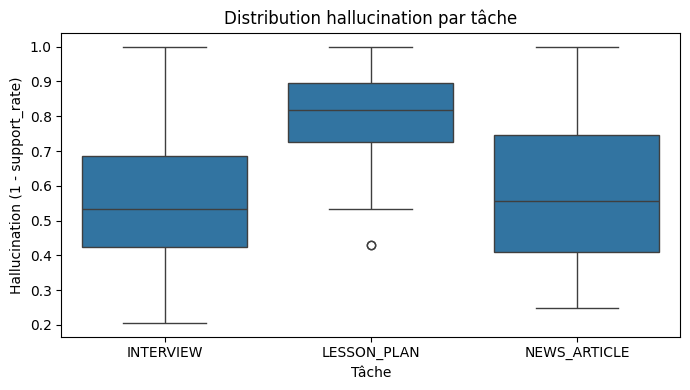

In [ ]:
# 2) Distribution par tâche
task_order = sorted(df_base['task'].dropna().unique())
plt.figure(figsize=(7,4))
sns.boxplot(data=df_base, x='task', y='hallucination_rate', order=task_order)
plt.title('Distribution hallucination par tâche')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


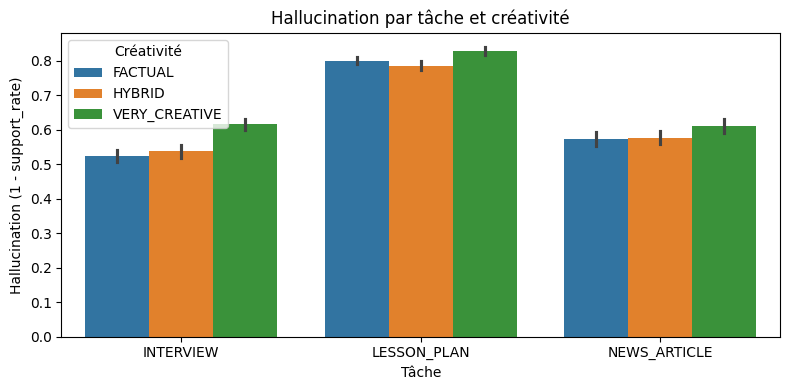

In [ ]:
# 3) Tâche x créativité
task_order = sorted(df_base['task'].dropna().unique())
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_base,
    x='task', y='hallucination_rate',
    hue='creativity_level',
    estimator='mean', errorbar='se',
    hue_order=CREATIVITY_ORDER,
    order=task_order
)
plt.title('Hallucination par tâche et créativité')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Créativité')
plt.tight_layout()
plt.show()


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_26406/2155150777.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_26406/2155150777.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_26406/2155150777.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


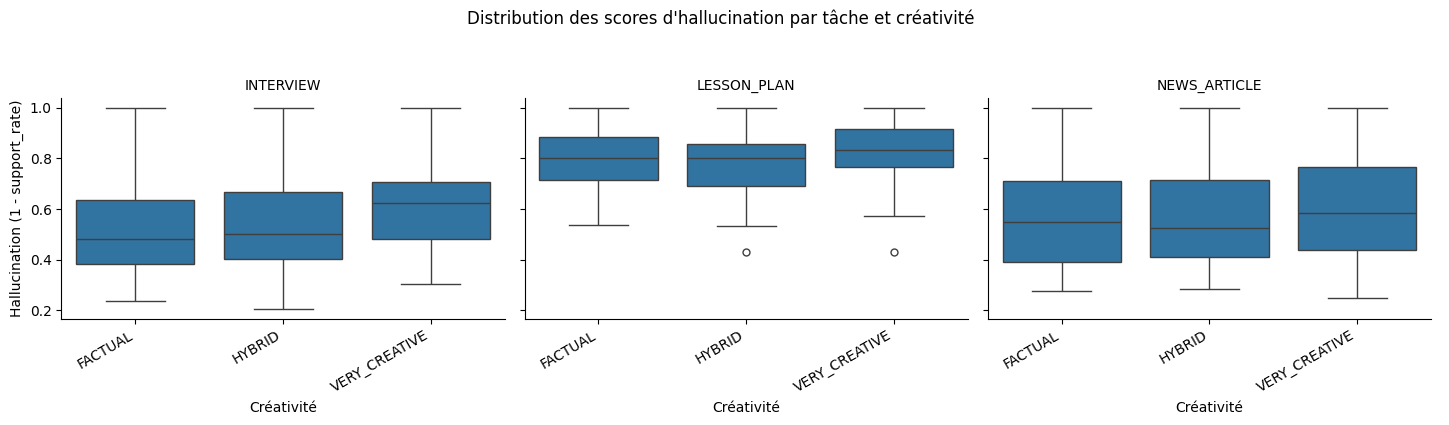

In [ ]:
# 3bis) Distribution des scores d'hallucination par tâche et créativité
task_order = sorted(df_base['task'].dropna().unique())
g = sns.catplot(
    data=df_base,
    x='creativity_level', y='hallucination_rate',
    col='task',
    kind='box',
    order=CREATIVITY_ORDER,
    col_order=task_order,
    height=4, aspect=1.2,
    sharey=True
)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
g.set_titles('{col_name}')
g.set_axis_labels('Créativité', 'Hallucination (1 - support_rate)')
g.fig.suptitle("Distribution des scores d'hallucination par tâche et créativité", y=1.05)
plt.tight_layout()
plt.show()


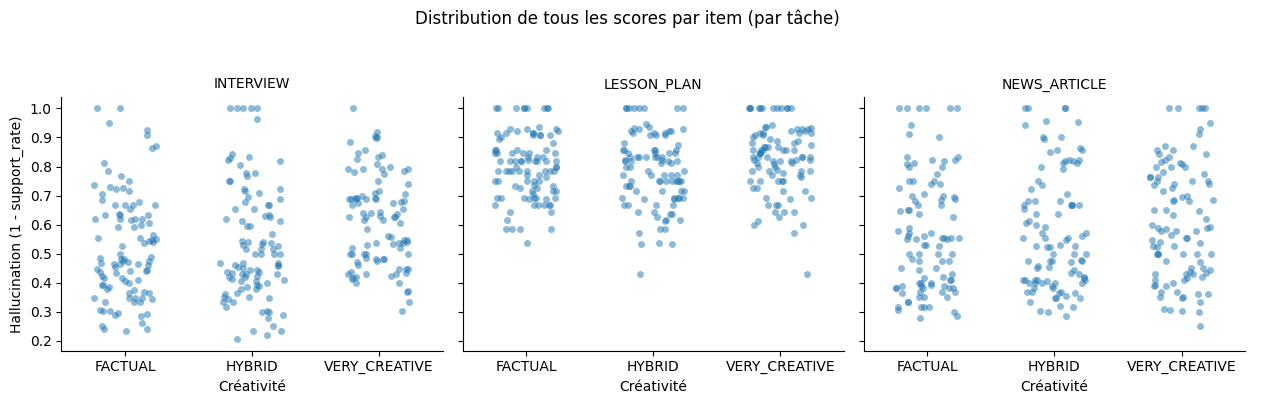

In [ ]:
# 3ter) Distribution de tous les scores par item (séparé par tâche et créativité)
task_order = sorted(df_base['task'].dropna().unique())
g = sns.catplot(
    data=df_base,
    x='creativity_level', y='hallucination_rate',
    col='task',
    kind='strip',
    order=CREATIVITY_ORDER,
    col_order=task_order,
    jitter=0.25, alpha=0.5,
    height=3.8, aspect=1.1,
    sharey=True
)
g.set_titles('{col_name}')
g.set_axis_labels('Créativité', 'Hallucination (1 - support_rate)')
g.fig.suptitle('Distribution de tous les scores par item (par tâche)', y=1.05)
plt.tight_layout()
plt.show()
